In [2]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

In [3]:
# Process Pokémon and one-hot encode the types

pokemon = pd.read_csv('../data/external/stats/pokemon.csv')
pokemon["Variety"] = float("NaN")
pokemon = pokemon[["#", "Name", "Variety", "Type 1", "Type 2"]]

# Create one-hot columns for each type
types = set(pokemon["Type 1"])
for t in types:
    pokemon["is" + str(t)] = 0

# Iterate over Pokémon
for i, p in pokemon.iterrows():
    
    # Clean up name
    pokemonName = pokemon.loc[i, "Name"]
    pokemonName = pokemonName.replace(" ", "")
    
    pokemonNameComponents = re.findall('[A-Z][^A-Z0-9]*', pokemonName)

    pokemon.loc[i, "Name"] = pokemonNameComponents[0]
    
    # Set variety (Mega etc.)
    if len(pokemonNameComponents) > 1:
        pokemonNameComponents = [value for value in pokemonNameComponents if value != pokemonNameComponents[0]]
        pokemon.loc[i, "Variety"] = str(pokemonNameComponents).lower()
    else:
        pokemon.loc[i, "Variety"] = "normal"
    
    #  Set one-hot columns to 1 for relevant types
    pokemon.loc[i, "is" + p["Type 1"]] = 1

    if not pd.isna(p["Type 2"]):
        pokemon.loc[i, "is" + p["Type 2"]] = 1

# Ditch all Pokemon with varieties (e.g. Megas):
pokemon = pokemon[pokemon["Variety"] == "normal"]


# Save output
pokemon.to_csv('../data/processed/pokemon.csv', index=False)

pokemon.head()

,#,Name,Variety,Type 1,Type 2,isPoison,isWater,isBug,isFairy,isIce,...,isFighting,isGrass,isRock,isDark,isPsychic,isFlying,isElectric,isFire,isDragon,isGround
0,1,Bulbasaur,normal,Grass,Poison,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,Ivysaur,normal,Grass,Poison,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,Venusaur,normal,Grass,Poison,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,4,Charmander,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,5,Charmeleon,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# Process image data

data_directory_images = "../data/external/images-gen-1-6"
output_directory = "../data/processed/pokemon"

pokemon = pd.read_csv('../data/processed/pokemon.csv')
pokemon["imagePath"] = np.nan

# Remove processed folder and create empty new one
try:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
except:
    os.mkdir(output_directory)

# Copy images to processed folder
for image in os.listdir(data_directory_images):
    pokemon_id = image.split('.')[0]

    # Images with no variety (e.g. "211.png")
    if pokemon_id.isnumeric():
        
        # Copy to processed folder
        src = data_directory_images + "/" + image
        dst = output_directory + "/" + pokemon_id + ".png"

        shutil.copyfile(src, dst)

        # Set image path in data frame
        pokemon.loc[pokemon["#"] == int(pokemon_id), 'imagePath'] = dst
        

# Drop Pokemon without image path
pokemon = pokemon.dropna(subset=["imagePath"])

# Save pokemon.csv with image paths
pokemon.to_csv('../data/processed/pokemon-with-image-paths.csv', index=False)

pokemon.head()

,#,Name,Variety,Type 1,Type 2,isPoison,isWater,isBug,isFairy,isIce,...,isGrass,isRock,isDark,isPsychic,isFlying,isElectric,isFire,isDragon,isGround,imagePath
0,1,Bulbasaur,normal,Grass,Poison,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,../data/processed/pokemon/1.png
1,2,Ivysaur,normal,Grass,Poison,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,../data/processed/pokemon/2.png
2,3,Venusaur,normal,Grass,Poison,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,../data/processed/pokemon/3.png
3,4,Charmander,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,../data/processed/pokemon/4.png
4,5,Charmeleon,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,../data/processed/pokemon/5.png


In [15]:
# Load images as training data
train_image = []

for i in tqdm(range(pokemon.shape[0])):
    
    img = tf.keras.utils.load_img(pokemon.iloc[i]["imagePath"])
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

X.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 693/693 [00:01<00:00, 539.56it/s]


(693, 256, 256, 3)

In [16]:
# Create labels

y = np.array(pokemon.drop(['#', 'Name', 'Variety', 'Type 1', 'Type 2', 'imagePath'], axis=1))

y.shape

(693, 18)

In [19]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(623, 256, 256, 3) (623, 18)
(70, 256, 256, 3) (70, 18)


In [20]:
# Create model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 126, 126, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 61, 61, 32)       

In [21]:
# Train model

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10


2022-07-05 14:42:03.363912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.0530

2022-07-05 14:42:07.471094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 5s 229ms/step - loss: 0.5515 - accuracy: 0.0530 - val_loss: 0.5369 - val_accuracy: 0.0714
Epoch 2/10
10/10 [==============================] - 2s 168ms/step - loss: 0.4372 - accuracy: 0.0530 - val_loss: 0.3648 - val_accuracy: 0.0714
Epoch 3/10
10/10 [==============================] - 2s 166ms/step - loss: 0.3842 - accuracy: 0.0626 - val_loss: 0.3997 - val_accuracy: 0.0714
Epoch 4/10
10/10 [==============================] - 2s 166ms/step - loss: 0.3526 - accuracy: 0.0770 - val_loss: 0.3731 - val_accuracy: 0.0714
Epoch 5/10
10/10 [==============================] - 2s 164ms/step - loss: 0.3265 - accuracy: 0.0578 - val_loss: 0.3509 - val_accuracy: 0.0714
Epoch 6/10
10/10 [==============================] - 2s 164ms/step - loss: 0.3168 - accuracy: 0.0658 - val_loss: 0.3772 - val_accuracy: 0.1571
Epoch 7/10
10/10 [==============================] - 2s 164ms/step - loss: 0.3107 - accuracy: 0.0915 - val_loss: 0.3578 - val_accuracy: 0.1000
Epoch 8/10
10/10 

1/1 [==============================] - 0s 16ms/step
isGrass (0.272)
isNormal (0.257)
isWater (0.255)


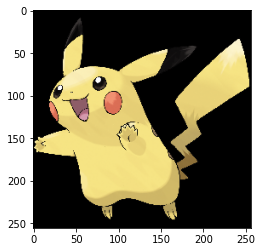

In [31]:
img = tf.keras.utils.load_img('../data/processed/pokemon/25.png',target_size=(256,256,3))
img = tf.keras.utils.img_to_array(img)
img = img/255


classes = np.array(pokemon.columns[5:-1])
proba = model.predict(img.reshape(1,256,256,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)